In [2]:
from typing import Optional, Tuple
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import json
#import imageio
import cv2
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
from PIL import Image

from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
def load_colmap_data():
    r"""
    After using colmap2nerf.py to convert the colmap intrinsics and extrinsics,
    read in the transform_colmap.json file

    Expected Returns:
      An array of resized imgs, normalized to [0, 1]
      An array of poses, essentially the transform matrix
      Camera parameters: H, W, focal length

    NOTES:
      We recommend you resize the original images from 800x800 to lower resolution,
      i.e. 200x200 so it's easier for training. Change camera parameters accordingly
    """
    ################### YOUR CODE START ###################

    json_path='transforms_colmap.json'
    image_dir='./data/data/images'

    json_path='/content/drive/MyDrive/ESE 650_HW3_P3/transforms_colmap.json'
    image_dir='/content/drive/MyDrive/ESE 650_HW3_P3/data/data/images'
    resize_dim=(200, 200)

    # Load JSON file
    with open(json_path, 'r') as f:
        data = json.load(f)

    # Initialize lists to store processed data
    imgs = []
    poses = []

    # Process each frame in the JSON file
    for frame in data['frames']:
        # Load and resize image
        img_path = os.path.join(image_dir, frame['file_path'][0])
        img = Image.open(img_path).resize(resize_dim)
        imgs.append(np.array(img) / 255.0)  # Normalize to [0, 1]

        # Process pose
        pose = np.array(frame['transform_matrix'])
        #print (pose)
        poses.append(pose)

    # Assuming all images have the same size and focal length
    H, W = resize_dim
    focal = frame["camera_angle_x"] * W / (2 * np.tan(frame['camera_angle_x'] / 2))

    # Convert lists to numpy arrays
    imgs = np.array(imgs)
    poses = np.array(poses)

    # Camera parameters: Height, Width, Focal length
    camera_params = (H, W, focal)

    return imgs, poses, camera_params
    ################### YOUR CODE END ###################


def get_rays(H, W, focal, c2w,):
    """
    Compute rays passing through each pixel in the world frame.

    Parameters:
    - H: Height of the image.
    - W: Width of the image.
    - focal: Camera intrinsic matrix of shape (3, 3).
    - c2w: Camera-to-world transformation matrix of shape (4, 4).

    Returns:
    - ray_origins: Array of shape (H, W, 3) denoting the origins of each ray.
    - ray_directions: Array of shape (H, W, 3) denoting the direction of each ray.
    """
    # Generate mesh grid for pixel coordinates

    # Detect if a GPU is available and choose the device accordingly
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    #device = 'cpu' #Due to OOM
    #print(device)

    # Ensure c2w is a torch.Tensor and move it to the chosen device
    if not isinstance(c2w, torch.Tensor):
        c2w = torch.from_numpy(c2w).float()  # Convert from numpy to tensor if necessary
    c2w = c2w.to(device)

    # Generate a grid of (i, j) coordinates
    i, j = torch.meshgrid(torch.linspace(0, W-1, W, device=device), torch.linspace(0, H-1, H, device=device))
    i = i.t().flatten()
    j = j.t().flatten()

    # Normalize pixel coordinates (assuming the image center as origin)
    dirs = torch.stack([(i - W * 0.5) / focal, -(j - H * 0.5) / focal, -torch.ones_like(i, device=device)], -1)

    # Rotate ray directions from camera frame to the world frame
    rays_d = torch.sum(dirs[..., None, :] * c2w[:3, :3], axis=-1)

    # The origin of all rays is the camera position in the world frame
    rays_o = c2w[:3, -1].expand(rays_d.shape)

    # Reshape rays_o and rays_d to [H, W, 3]
    rays_o = rays_o.view(H, W, 3)
    rays_d = rays_d.view(H, W, 3)

    return rays_o, rays_d

def sample_points_from_rays(ray_origins, ray_directions, snear, sfar, Nsample):
    """
    Sample 3D points along rays within the specified near and far bounds.

    Parameters:
    - ray_origins: Array of shape (H, W, 3) denoting the origins of each ray.
    - ray_directions: Array of shape (H, W, 3) denoting the direction of each ray.
    - snear: Scalar or array defining the near clipping distance for each ray.
    - sfar: Scalar or array defining the far clipping distance for each ray.
    - Nsample: Number of points to sample along each ray.

    Returns:
    - sampled_points: Array of shape (H, W, Nsample, 3) with sampled 3D points.
    - depth_values: Array of shape (H, W, Nsample) with depth values of sampled points.
    """

    # Make sure snear and sfar are tensors
    H, W, _ = ray_origins.shape
    device = ray_origins.device


    # Compute the depth values for each sample
    depth_values = torch.linspace(snear, sfar, Nsample, device=device)

    depth_values = depth_values.expand(H, W, Nsample)  # Make sure depth values have shape (H, W, Nsample)

    # Compute the 3D positions of each sample point along the rays
    sampled_points = ray_origins[..., None, :] + depth_values[..., :, None] * ray_directions[..., None, :]  # Correct shape: (H, W, Nsample, 3)

    return sampled_points, depth_values


def positional_encoding(x, max_freq_log2=10, include_input=True):

    """Apply positional encoding to the input. (Section 5.1 of original paper)
    We use positional encoding to map continuous input coordinates into a
    higher dimensional space to enable our MLP to more easily approximate a
    higher frequency function.

    Expected Returns:
      pos_out: positional encoding of the input tensor.
               (H*W*num_samples, (include_input + 2*freq) * 3)
    """
    frequencies = 2 ** torch.linspace(0, max_freq_log2, steps=max_freq_log2+1, device=x.device)
    # Create a list of frequencies, (sin(2^k * x), cos(2^k * x)) for k=0,...,max_freq_log2
    encodings = [torch.sin(x * freq) for freq in frequencies] + [torch.cos(x * freq) for freq in frequencies]
    # Stack all encodings along the last dimension
    encoded = torch.cat(encodings, dim=-1)

    if include_input:
        # Concatenate the original input with the encoded features
        pos_out = torch.cat([x, encoded], dim=-1)
    else:
        pos_out = encoded

    return pos_out


def volume_rendering(
    radiance_field: torch.Tensor,
    ray_origins: torch.Tensor,
    depth_values: torch.Tensor
) -> Tuple[torch.Tensor]:
    """
    Differentiably renders a radiance field, given the origin of each ray in the bundle,
    and the sampled depth values along them.

    Args:
      radiance_field: Tensor containing RGB color and volume density at each query location,
                      shape (H, W, num_samples, 4).
      ray_origins: Origin of each ray, shape (H, W, 3).
      depth_values: Sampled depth values along each ray, shape (H, W, num_samples).

    Returns:
      rgb_map: Rendered RGB image, shape (H, W, 3).
    """
    # Extract sigma (density) and color from the radiance field
    sigma = torch.relu(radiance_field[..., 3])  # Extract volume density
    rgb = torch.sigmoid(radiance_field[..., :3])  # Extract RGB colors

    # Compute depth intervals
    dists = torch.cat([depth_values[..., 1:] - depth_values[..., :-1], torch.tensor([1e10], device=device).expand(depth_values[..., :1].shape)], dim=-1)
    alpha = 1.0 - torch.exp(-sigma * dists)
    weights = alpha * torch.cumprod(torch.cat([torch.ones_like(alpha[..., :1]), 1.0 - alpha + 1e-10], dim=-1), dim=-1)[..., :-1]

    rgb_map = torch.sum(weights[..., None] * rgb, dim=-2)

    return rgb_map

class TinyNeRF(torch.nn.Module):
    def __init__(self, pos_dim, fc_dim=128):
      r"""Initialize a tiny nerf network, which composed of linear layers and
      ReLU activation. More specifically: linear - relu - linear - relu - linear
      - relu -linear. The module is intentionally made small so that we could
      achieve reasonable training time

      Args:
        pos_dim: dimension of the positional encoding output
        fc_dim: dimension of the fully connected layer
      """
      super().__init__()

      self.nerf = nn.Sequential(
                    nn.Linear(pos_dim, fc_dim),
                    nn.ReLU(),
                    nn.Linear(fc_dim, fc_dim),
                    nn.ReLU(),
                    nn.Linear(fc_dim, fc_dim),
                    nn.ReLU(),
                    nn.Linear(fc_dim, 4)
                  )

    def forward(self, x):
      r"""Output volume density and RGB color (4 dimensions), given a set of
      positional encoded points sampled from the rays
      """
      x = self.nerf(x)
      return x


def get_minibatches(inputs: torch.Tensor, chunksize: Optional[int] = 1024 * 8):
    r"""Takes a huge tensor (ray "bundle") and splits it into a list of minibatches.
    Each element of the list (except possibly the last) has dimension `0` of length
    `chunksize`.
    """
    return [inputs[i:i + chunksize] for i in range(0, inputs.shape[0], chunksize)]


def nerf_step_forward(height, width, focal_length, trans_matrix,
                            near_point, far_point, num_depth_samples_per_ray,
                            get_minibatches_function, model):
    r"""Perform one iteration of training, which take information of one of the
    training images, and try to predict its rgb values

    Args:
      height: height of the image
      width: width of the image
      focal_length: focal length of the camera
      trans_matrix: transformation matrix, which is also the camera pose
      near_point: threshhold of nearest point
      far_point: threshold of farthest point
      num_depth_samples_per_ray: number of sampled depth from each rays in the ray bundle
      get_minibatches_function: function to cut the ray bundles into several chunks
        to avoid out-of-memory issue

    Expected Returns:
      rgb_predicted: predicted rgb values of the training image
    """
    ################### YOUR CODE START ###################

    # Step 1: Generate rays
    # Assuming an implementation of `get_rays` function that returns ray origins and directions
    ray_origins, ray_directions = get_rays(height, width, focal_length, trans_matrix)
    # print("ray_origins",ray_origins.shape)
    # print("ray_directions",ray_directions.shape)
    # print(f"ray_origins is stored on: {ray_origins.device}")
    # print(f"ray_directions is stored on: {ray_directions.device}")

    # Step 2: Sample points along each ray
    # Assuming an implementation of `sample_points_from_rays` that returns sampled points and depth values
    sampled_points, depth_values = sample_points_from_rays(ray_origins, ray_directions, near_point, far_point, num_depth_samples_per_ray)
    # print("sampled_points",sampled_points.shape)
    # print("depth_values",depth_values.shape)
    # print(f"sampled_points is stored on: {sampled_points.device}")
    # print(f"depth_values is stored on: {depth_values.device}")

    # Step 3: Apply positional encoding
    # Assuming `positional_encoding` expects a flattened list of points
    flattened_sampled_points = sampled_points.reshape(-1, 3)  # Flattening sampled points for positional encoding
    positional_encoded_points = positional_encoding(flattened_sampled_points)  # Apply positional encoding
    # print("positional_encoded_points",positional_encoded_points.shape)
    # print(f"positional_encoded_points is stored on: {positional_encoded_points.device}")


    # Step 4: Run the model in batches
    # Splitting the points into manageable chunks to avoid OOM
    batches = get_minibatches_function(positional_encoded_points, chunksize=16384)
    predictions = []
    for batch in batches:
        #print(batch.shape)
        predictions.append(model(batch))

    radiance_field_flattened = torch.cat(predictions, dim=0)

    ################### YOUR CODE START ###################

    # Step 5: Volume rendering
    # Reshape the radiance field to its unflattened shape
    radiance_field = radiance_field_flattened.view(height, width, num_depth_samples_per_ray, 4)
    #print(f"radiance_field is stored on: {radiance_field.device}")


    # Assuming an implementation of `volume_rendering` that takes the radiance field, ray origins, and depth values
    rgb_predicted = volume_rendering(radiance_field, ray_origins, depth_values)
    #print("rgb_predicted",rgb_predicted.shape)


    return rgb_predicted



def train(images, poses, hwf, near_point,
          far_point, num_depth_samples_per_ray,
          num_iters, model, History,DEVICE="cuda"):
    r"""Training a tiny nerf model

    Args:
      images: all the images extracted from dataset (including train, val, test)
      poses: poses of the camera, which are used as transformation matrix
      hwf: [height, width, focal_length]
      near_point: threshhold of nearest point
      far_point: threshold of farthest point
      num_depth_samples_per_ray: number of sampled depth from each rays in the ray bundle
      num_iters: number of training iterations
      model: predefined tiny NeRF model
    """


    H, W, focal_length = hwf
    H = int(H)
    W = int(W)
    n_train = images.shape[0]
    print(H)

    # Optimizer parameters
    lr = 5e-3
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Seed RNG, for repeatability
    seed = 9458
    torch.manual_seed(seed)
    np.random.seed(seed)


    for _ in tqdm(range(num_iters)):
      # Randomly pick a training image as the target, get rgb value and camera pose
      train_idx = np.random.randint(n_train)
      train_img_rgb = images[train_idx, ..., :3]
      train_pose = poses[train_idx]

      # Run one iteration of TinyNeRF and get the rendered RGB image.
      rgb_predicted = nerf_step_forward(H, W, focal_length,
                                              train_pose, near_point,
                                              far_point, num_depth_samples_per_ray,
                                              get_minibatches, model)


      train_img_rgb_tensor = torch.from_numpy(train_img_rgb)
      train_img_rgb= train_img_rgb_tensor.to(DEVICE).to(dtype=torch.float32)


      # Compute mean-squared error between the predicted and target images
      loss = torch.nn.functional.mse_loss(rgb_predicted, train_img_rgb)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      History.append(loss.cpu().detach().numpy())


      if _ % 200 == 0:
            with torch.no_grad():
                plt.figure(figsize=(10, 4))

                plt.subplot(121)
                plt.imshow(train_img_rgb_tensor.cpu().numpy())
                plt.title(f"Target Image at Iteration {_}")

                plt.subplot(122)
                plt.imshow(rgb_predicted.detach().cpu().numpy())
                plt.title(f"Predicted Image at Iteration {_}")

                plt.show()

                print('Loss at '+str(_)+" iterations: ",loss.cpu().detach().numpy())

    print('Finish training')



100


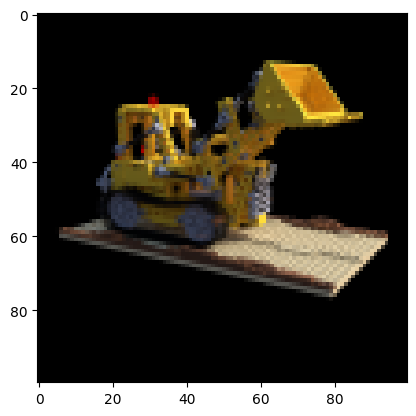

100


  0%|          | 0/2000 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


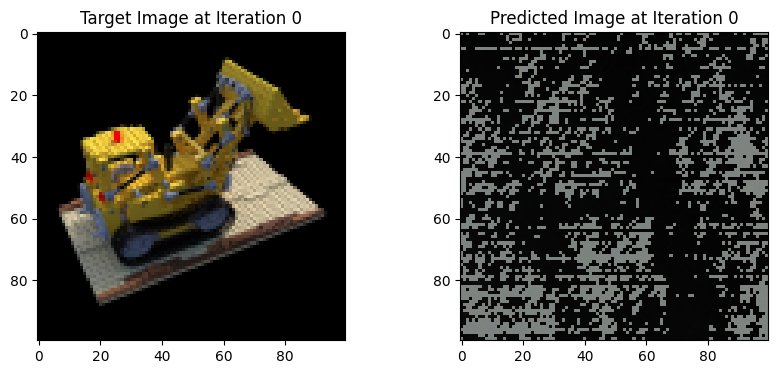

  0%|          | 1/2000 [00:08<4:49:22,  8.69s/it]

Loss at 0 iterations:  0.102328695


 10%|█         | 200/2000 [21:17<3:04:40,  6.16s/it]

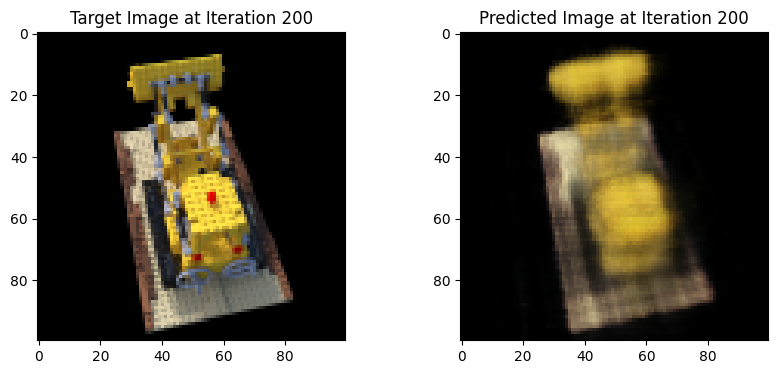

 10%|█         | 201/2000 [21:24<3:12:59,  6.44s/it]

Loss at 200 iterations:  0.010660882


 20%|██        | 400/2000 [42:24<3:01:35,  6.81s/it]

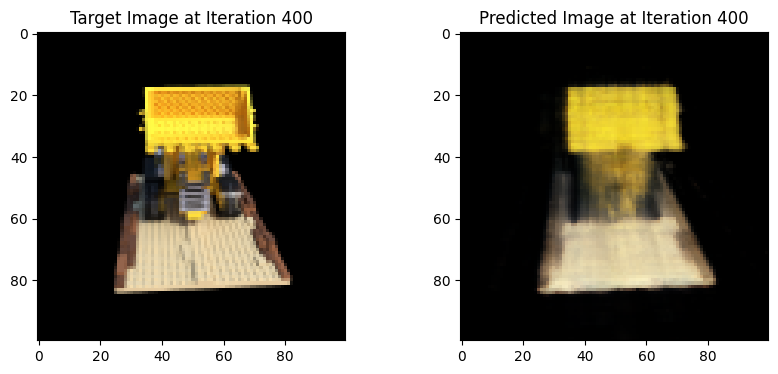

 20%|██        | 401/2000 [42:30<2:58:43,  6.71s/it]

Loss at 400 iterations:  0.0045363167


 30%|███       | 600/2000 [1:04:52<2:41:39,  6.93s/it]

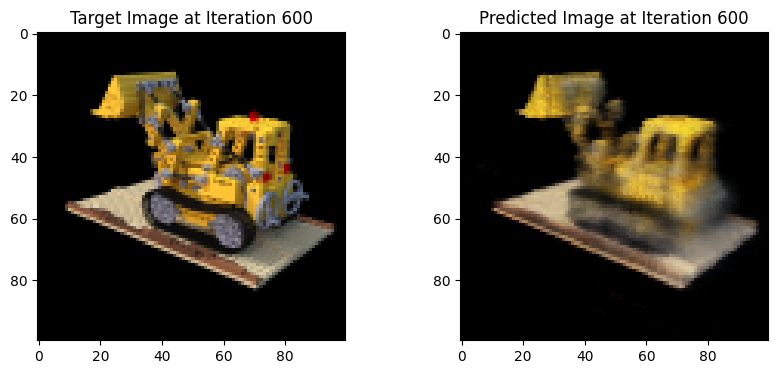

 30%|███       | 601/2000 [1:04:59<2:41:29,  6.93s/it]

Loss at 600 iterations:  0.0077882637


 40%|████      | 800/2000 [1:26:38<2:07:59,  6.40s/it]

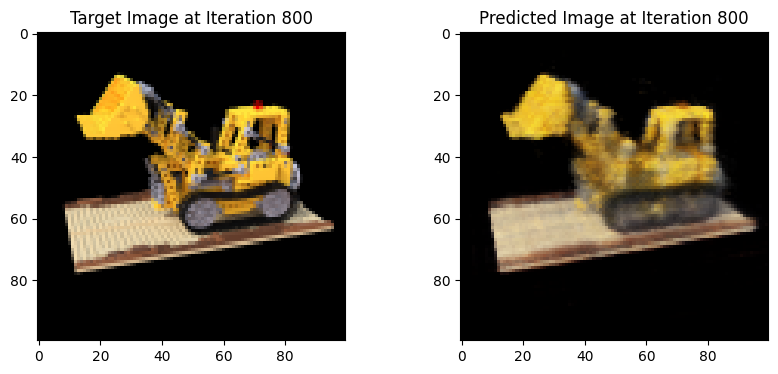

 40%|████      | 801/2000 [1:26:44<2:06:12,  6.32s/it]

Loss at 800 iterations:  0.0068901475


 50%|█████     | 1000/2000 [1:48:24<1:54:48,  6.89s/it]

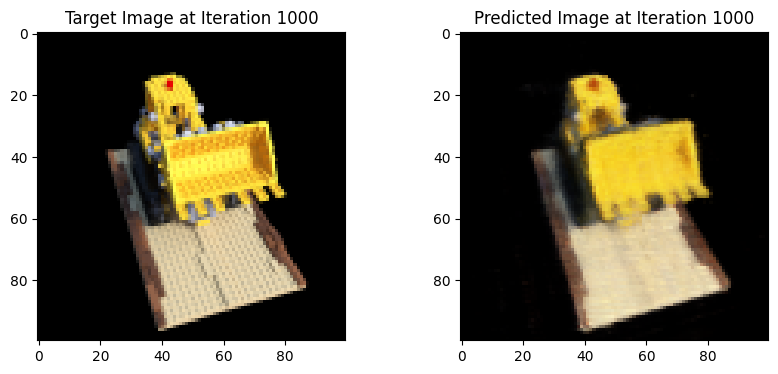

 50%|█████     | 1001/2000 [1:48:31<1:53:51,  6.84s/it]

Loss at 1000 iterations:  0.004944582


 60%|██████    | 1200/2000 [2:11:22<1:33:11,  6.99s/it]

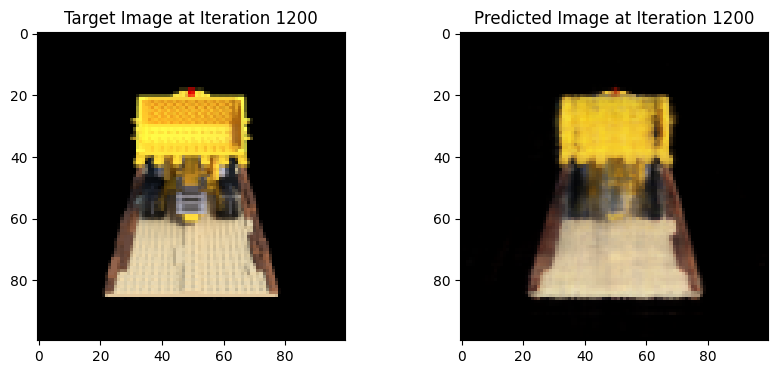

 60%|██████    | 1201/2000 [2:11:30<1:34:19,  7.08s/it]

Loss at 1200 iterations:  0.0037400422


 70%|███████   | 1400/2000 [2:33:17<1:07:05,  6.71s/it]

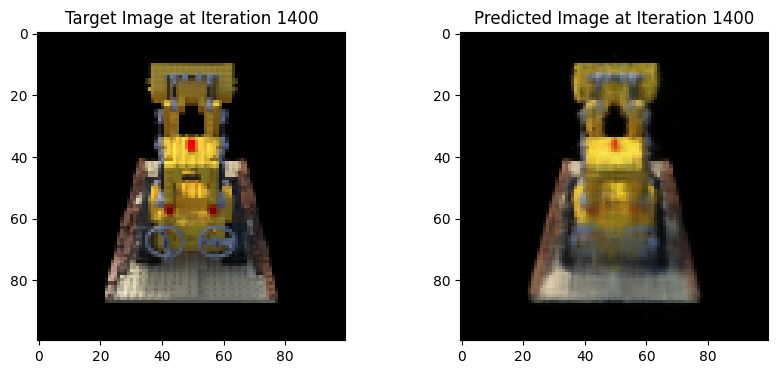

 70%|███████   | 1401/2000 [2:33:24<1:07:08,  6.73s/it]

Loss at 1400 iterations:  0.0027531914


 80%|████████  | 1600/2000 [2:55:18<44:00,  6.60s/it]

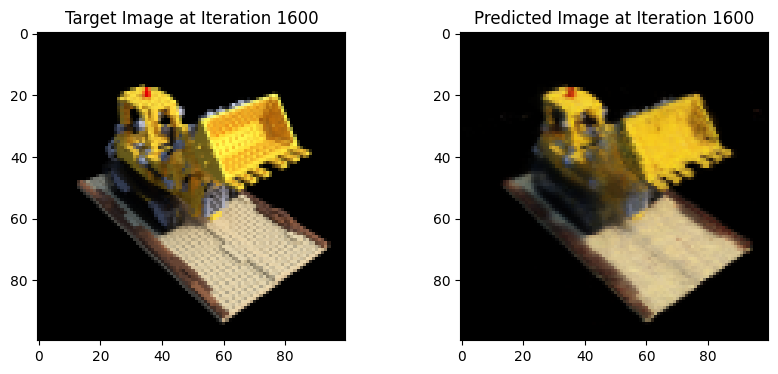

 80%|████████  | 1601/2000 [2:55:24<43:05,  6.48s/it]

Loss at 1600 iterations:  0.004221846


 90%|█████████ | 1800/2000 [3:17:38<22:19,  6.70s/it]

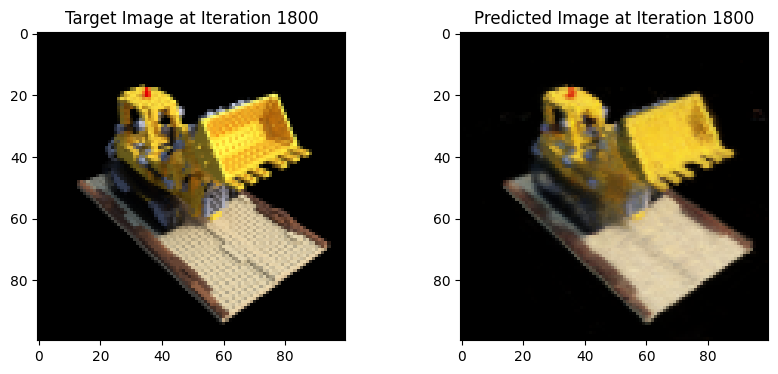

 90%|█████████ | 1801/2000 [3:17:44<21:37,  6.52s/it]

Loss at 1800 iterations:  0.0037196036


100%|██████████| 2000/2000 [3:40:06<00:00,  6.60s/it]

Finish training


In [5]:

 if __name__ == "__main__":
    images, poses, hwf=load_colmap_data()
    #print(type(images[0,:,:,:]))


    #images = data["images"]
    #im_shape = images.shape
    #(num_images, H, W, _) = images.shape
    poses= np.array(data["poses"])
    print (H)
    hwf = np.array([H, W, focal])

    # If plotting or processing images, ensure conversion is safe
    plt.imshow(images[np.random.randint(low=0, high=num_images)])
    plt.show()



    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    #device = 'cpu' #Due to OOM
    near_point=2.
    far_point=6.
    num_depth_samples_per_ray = 96
    num_iters = 2000
    model = TinyNeRF(69)
    model.to(device)

    History=[]
    train(images, poses, hwf, near_point,
              far_point, num_depth_samples_per_ray,
              num_iters, model, History,DEVICE=device)



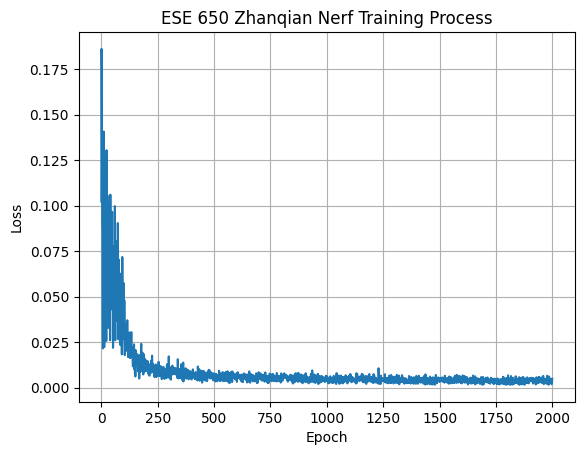

In [6]:
plt.plot(History)
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("ESE 650 Zhanqian Nerf Training Process")
plt.show()